In [28]:
# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [29]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
# from __future_ _import division ~ how do you get the double bottom line
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [30]:
# TODO: Total number of records
n_records = len(data)
print n_records

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data.income ==">50K"])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data.income =="<=50K"])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent =  100.0 * n_greater_50k / n_records 

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

45222
Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

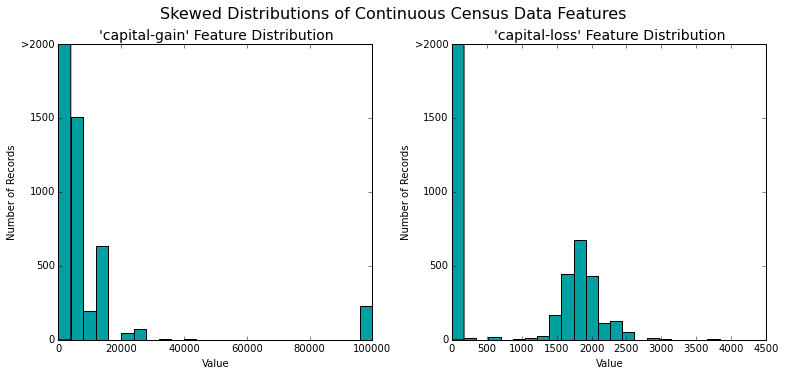

In [31]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

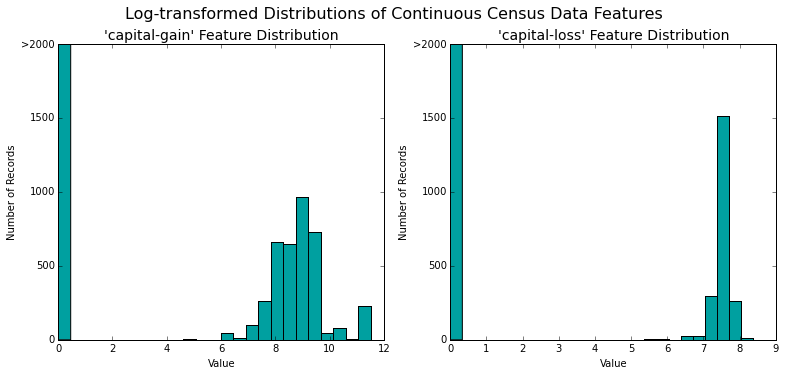

In [32]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [33]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [34]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
#pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False)[source]
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K'  else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [35]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [36]:
# TODO: Calculate accuracy
accuracy = greater_percent / 100.0


# TODO: Calculate F-score using the formula above for beta = 0.5
beta =  0.5

#Recall = Tp/Tp+Fn = n_greater_50K/n_greater_50K = 1
recall = 1.0

fscore = (1 + beta**2) * accuracy * recall / (beta**2 * accuracy + recall)
print fscore

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)


0.291729135432
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*


1) GradientBoostingClassifier:
     Real-World Application:  The infamous Netflix competition (for the best collaborative filtering algorithm to predict user ratings for films)
     was won with a gradient boosted decision trees to combine over 500 models:
     http://blog.echen.me/2011/10/24/winning-the-netflix-prize-a-summary/
     
     Strengths: Naturally handles mixed data types and is robust to outliers.  Has better predictive powers than many other algorithms.
     
     Weaknesses:  Picking the learning rate that is both efficient and quick is difficult and can add to losses.  It is a challenge to
     minimize highly non-convex error functions (common for neural networks) and avoid getting trapped in numerous suboptimal 
     local minima.   GBCs usually perform better than most algoritms but they require more work such as more hyper-parameter tuning and are
     more prone to overfitting compared to RFCs. 
     
     Why its a good candidate?   GBC is one of the most effective predictive algorithm and it excels when data samples are less than 100K, 
     text has been converted to numeric data, and KNeighbor Classifiers aren't performing well.  
     
2) RandomForestClassifier:
    
     Real-World Application:  Random Forests Classifiers are widely used in applications, such as gene expression analysis, protein-
     protein interactions, identification of biological sequences, genome-wide association studies, credit scoring or image processing:
     https://arxiv.org/pdf/1508.04409.pdf
     
     Strengths: Random Forests are fast, flexible, and represent a robust approach to mining high-dimensional data.  RFCs peform well even 
     in the presence of a large number of features and a small number of observations.  Bagging trees like this improves the predictive 
     performance over a single tree by reducing variance of the prediction. 
    
     Weakness ~  While RFC are quick to train they are slow to predict.  More accurate ensembles require more trees so RFC should be avoided 
     if run-time performance is an issue.  RFC is a predictive tool but not a descriptive tool so this is not to be used for describing the 
     relationships between data.   It can be difficult to intrepret multiple trees as opposed to a single tree model. 
     
     Why its a good candidate?   Similar to GBCs, RFCs excel when data samples are less than 100K, text has been converted to
     numeric data, and KNeighbor Classifiers aren't performing well.  
      
  3) Support Vector Machines:
     Real-World Application:  SVMs are helpful in text and hypertext categorization as their application can significantly reduce the need for 
     labeled training instances in both the standard inductive and transductive settings:
     https://en.wikipedia.org/wiki/Support_vector_machine
     
     Strengths:  SVCs have a regularizaton paramter which makes the user think how to avoid overfitting.  SVCs use the kernel trick making 
     it easier to engineer expert knowledge into the kernel. SVMs are defined by efficent convex methods avoiding local minima problems.  On the
     other hand, SVCs kernels implicit non-linear transformations are based upon a robust theoretical foundation that removes the need for 
     human expertise judgement beforehand.  Soft margin variants allow dealing with outliners elegantly. The max-margin idea is very intuitive
     to understand. 
     
     Weaknesses:  They can be painfully inefficent to train. A big SVC limitation can lie in the selection and complexity of kernels. 
        
     Why its a good candidate?  Via the kernel, SVCs can gain a flexibility in threshold formation choices seperating classification.   SVC  are 
     also a smart selection given the data sample criteria used for chosing GBCs and RFCs (excel when data samples are less than 100K, text 
     has been converted to numeric data, and KNeighbor Classifiers aren't performing well.   In this case, the first model selected (Linear SVC) 
     worked best.
             

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [37]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    from sklearn.metrics import accuracy_score
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta= 0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, average='binary', beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
LinearSVC trained on 361 samples.
LinearSVC trained on 3617 samples.
LinearSVC trained on 36177 samples.


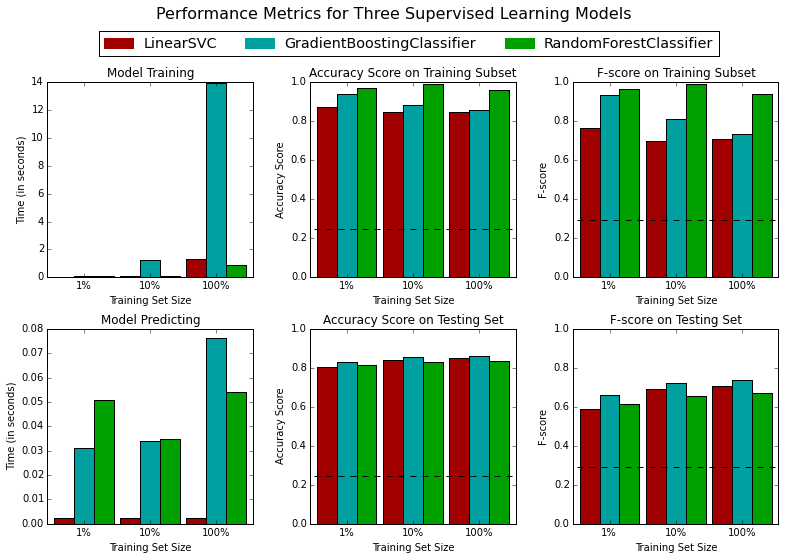

In [38]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# TODO: Initialize the three models
clf_A = GradientBoostingClassifier(random_state=10)
clf_B = RandomForestClassifier(random_state=10)
clf_C = LinearSVC(random_state=150)
clf_D = LogisticRegression(random_state=150)
clf_E = SGDClassifier(random_state=10)
                   
# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
n_train = len(y_train)
samples_1 = int(n_train * 0.01)
samples_10 = int(n_train * 0.1)
samples_100 = n_train 

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C,]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

vs.evaluate(results, accuracy, fscore)


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

In [ ]:
### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most
appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

Gradient Boosting Classifier (GBC) is the chosen model due to its prediction/training times, testing accuracy, testing F-score and suitability for this data.  

It is noteworthy, that for 100% of the data, the training time for GBC is significantly larger than other models and prediction time is 
15x larger than the LinearSVC.  When you compare the testing time differences below, GBC scalability is not as scalable as LSVC.  Compared to RFC, it is .02 second quicker at 1% of data and .001 a second quicker at 10% of data.  However at 100% of data, GBC is .022 second slower:
                LSVC       RFC         GBC
    1%         .002       .05          .03
  10%         .002       .034        .033
100%         .002       .053        .075


Despite GBC's higher training times and its higher testing time at 100% of data, these are minimum time expenses given GBC is the consistent winner at 1%, 10%, and 100% of data for both important testing accuracy and F-scores.  The finall result:

Compared to the Linear SVC (LSVC) and Random Forest Classifier (RFC) model results, at 100% of data GBC had both the higher test data accuracy score (0.8673) and a higher  F-score(0.7460).   

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*



Gradient Descent (GD) can be applied an number of algorithms (linear regression) and models such as the winning Netflix classifier which applied 
Gradient Descent to over 500 models looking for the optimal classification solution.   Below is explanation on how GD works with links for more
information that unpacks the intuition and math behind GD in detail:

To intuitively understand how the gradient descent classifier algorithm works to find the optimal solution with the lowest cost/error, imagine 
you're a hiker who is overlooking a valley and you want to hike into the valley to find the lowest flattest point in the valley.   
Finding the lowest flattest point, means out of all topographical ascents and descents we find the absolute lowest altitude possible and 
within this lowest altitude spot we are on the one spot where it is not possible to ascent and descent in any direction anymore.

Now imagine when approaching this flattest-lowest point, you measure the length of your steps taken looking for the perfect repeatable length 
that will bring you to stand precisely on this lowest zero-slope point in the quickest amount of time.   With a little experience, one establishing a 
“learning rate” that is measured by the length of the repeated steps estimated to bring one to the precise lowest altitude and sloped as quick as 
possible. We are looking for the lowest cost/error by descending into a valley framed by three axes:  slope (m), intercept (b) and error.

The way this works is Gradient descent is a first-order iteration optimization algorithm that for each i iteration creates an ith learner and then tests it on the training data set predicting a y' for each y.  Optimally, y' will equal y.  When y' doesn't equal y, a new learner is iteratively created trying to predict the measures (y - y') per the training set.  The process of learner seeking to learn from this measure continues for each i + ith iteration until the process is stoped. 
  
For more information on the Gradient-Descent Intuition please refer to this Andrew Ng lecture link:
Gradient Descent Intuition - Stanford University | Coursera
https://www.coursera.org/learn/machine-learning/lecture/GFFPB/gradient-descent-intuition

For more information on Gradient-Descent math, please refer to this Andrew Ng lecture link:
Gradient Descent - Stanford University | Coursera
https://www.coursera.org/learn/machine-learning/lecture/8SpIM/gradient-descent




### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [39]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state=10)
#clf = LogisticRegression(random_state=150)

#TODO: Create the parameters list you wish to tune
parameters = {'max_depth': [1,2,4,8],
                          'n_estimators': [150, 300, 500],
                          'learning_rate': [.1, 1.0, 1.5]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8673
Final F-score on the testing data: 0.7460


In [40]:
#clf_D
#best_clf

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

In [ ]:

# Metric	                     Benchmark Predictor	  Unoptimized Model	       Optimized Model
#Accuracy Score	                     0.2478	                        0.8630	                         0.8673
#F-score	                                0.2917	                       0.7395	                        0.7460


**Answer: **

The optimized model's accuracy and F-score are respectively 0.8673 and 0.7460. These scores are better than the unoptimized model. The unoptimized model's accuracy and F-score are respectively 0.8630 and 0.7395. The accuracy and F-score also really improved compared to the naive predictor benchmarks. The naive predictor benchmarks's accuracy and F-score are respectively 0.2478 and 0.2917.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

In [42]:
print data.columns.values

['age' 'workclass' 'education_level' 'education-num' 'marital-status'
 'occupation' 'relationship' 'race' 'sex' 'capital-gain' 'capital-loss'
 'hours-per-week' 'native-country' 'income']


**Answer: 
    
    The five features most important features predicted ranked in order of importance are:  
        occupation, capital gains, age, education level and hours per week:
        
     Occupation:  Occupation categories are expect to have a relationship with income.  Doctors, lawyers,  and senior executives are examples of 
        occupations likely to have have incomes higher than 50K. 
           
     Capital gain:  Given this model's mission of predicting whom makes more than $50K a year,anyone experiencing capital gains, is likely to 
        make $50K a year or more. 
        
     Age:  There is likely to be a correlation between age and incomes. 
        
     Education level:  This is likely a relationship between higher education and high income.  Specializations that require higher and continued
        education  are likely to pay $50K or more a year. 
        
     Hours per week:  It makes sense that employees working long hours are getting paid for them directly or indirectly: therefore, this feature 
     has a  relatively high probability to correlate well with incomes over $50K. 
        

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

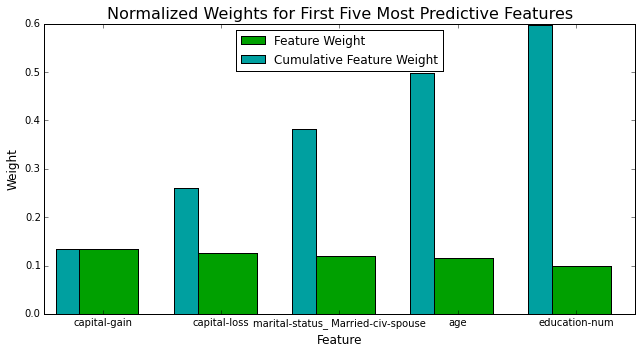

In [43]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer

# TODO: Train the supervised model on the training set 
model = GradientBoostingClassifier().fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

Not sure 3.5 is close or not but the visualization's biggest surprise for me was learning that married is third  in feature importance after capital gains and losses.  I understood that anyone who is realizing capital gains is probably making more than $50K a year and should have realized that those experiening capital losses have extra money invested so they are just as likely to make more than $50K a year so the first two important features make sense to me.  However, now that I think about it being married means more likely to have two incomes and it is very likely that two people together make more than $50K a year.   Predicted education as fifth so no surprises on this one.     With the benefit of hindsight, I can see how many people hold multiple jobs to get by but can still not make more than 50K a year.  Finally, it still makes sense to me that occupations can have high correlations with high incomes so I wonder what rank importance occupation has compared to the other features not in the top five. 



### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [46]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search with all features
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
train_time_all = end - start

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Train on the "best" model found from grid search after feature reduction
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
train_time_reduced = end - start

start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
test_time_reduced = end - start

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "Training Time Full Model: {:.4f}".format(train_time_all)
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))
print "Training Time Reduced Model: {:.4f}".format(train_time_reduced)

Final Model trained on full data
------
Accuracy on testing data: 0.8673
F-score on testing data: 0.7460
Training Time Full Model: 4.8182

Final Model trained on reduced data
------
Accuracy on testing data: 0.8594
F-score on testing data: 0.7289
Training Time Reduced Model: 4.8808


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

Given that the full data model performed better than the reduced data model and time gains are with the full data model, I would not consider using the reduced data as my training set.

The GBC model is apparently alittle bit more optimized and robust with the full data set instead of the reduced data set when reviewing acurracy and F-scores.   